In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np

In [3]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z
    
    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad
    
    def add_bias(self, x):
        return np.c_[np.ones((x.shape[0], 1)), x]
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + (self.l2 / 2) * np.sum(self.w**2)
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:
                z = self.forpass(x[i])
                a = self.activation(z)
                err = -(y[i] - a)
                w_grad, b_grad = self.backprop(x[i], err)
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad
                self.b -= b_grad
                self.w_history.append(self.w.copy())
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += - (y[i] * np.log(a) + (1 - y[i]) * np.log(1 - a))
            self.losses.append((loss / len(y)) + self.reg_loss())
            self.update_val_losses(x_val, y_val)
            
    def update_val_losses(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += - (y_val[i] * np.log(a) + (1 - y_val[i]) * np.log(1 - a))
        self.val_losses.append((val_loss / len(y_val)) + self.reg_loss())
            
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    

In [4]:
from sklearn.datasets import load_breast_cancer

In [5]:
cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

In [7]:
from sklearn.model_selection import train_test_split

In [11]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print("train: %d" % x_train.shape[0])
print("val: %d" % x_val.shape[0])
print("test: %d" % x_test.shape[0])

train: 364
val: 91
test: 114


In [8]:
import matplotlib.pyplot as plt

['mean perimeter' 'mean area']


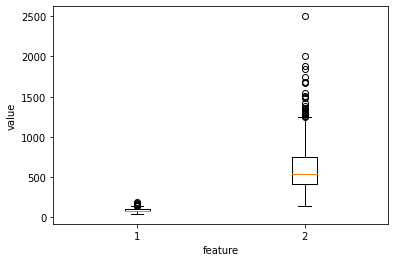

In [9]:
print(cancer.feature_names[[2, 3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [17]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/home/llewyn/projects/venvs/do_it_dl/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp


0.8461538461538461

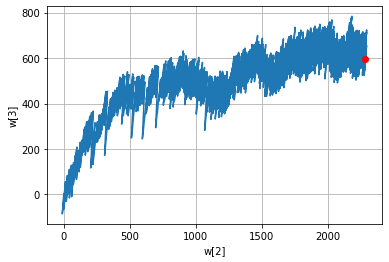

In [19]:
w2 = []
w3 = []
for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])

plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.grid()
plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [46]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

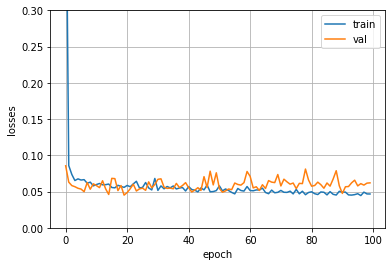

In [48]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.xlabel("epoch")
plt.ylabel("losses")
plt.legend(["train", "val"])
plt.grid()
plt.show()

In [49]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

0.978021978021978

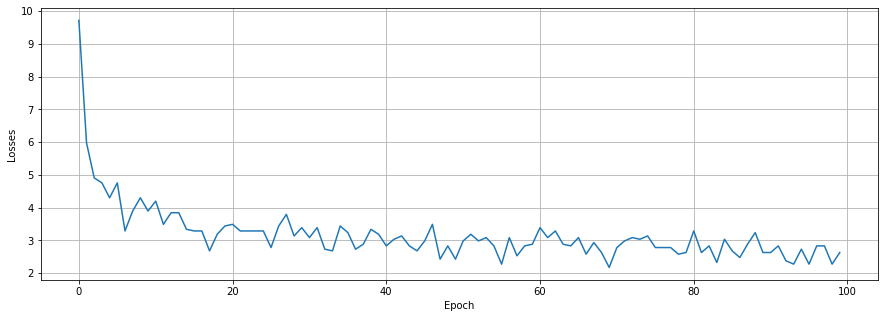

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(layer.losses)
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.grid()
plt.show()

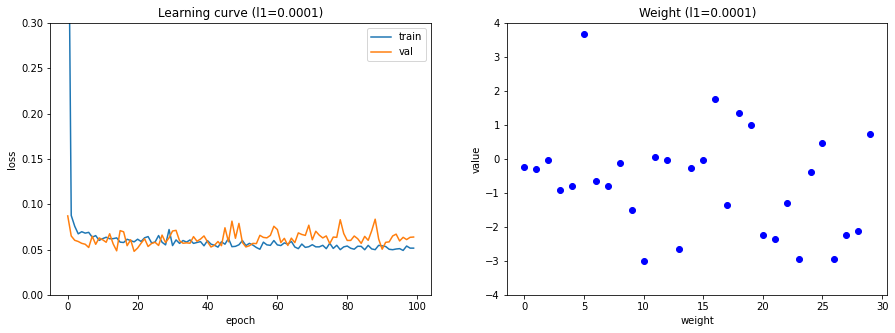

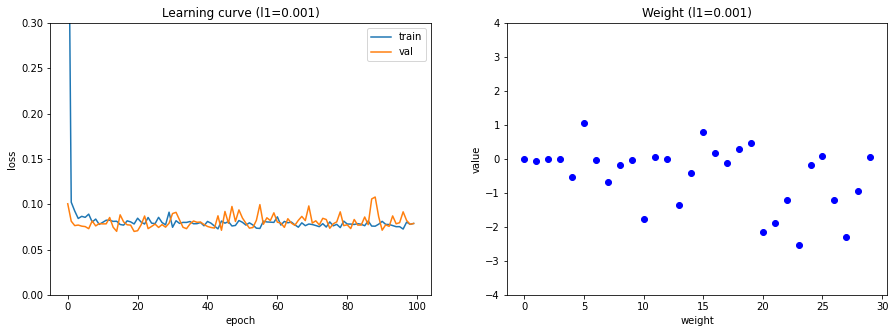

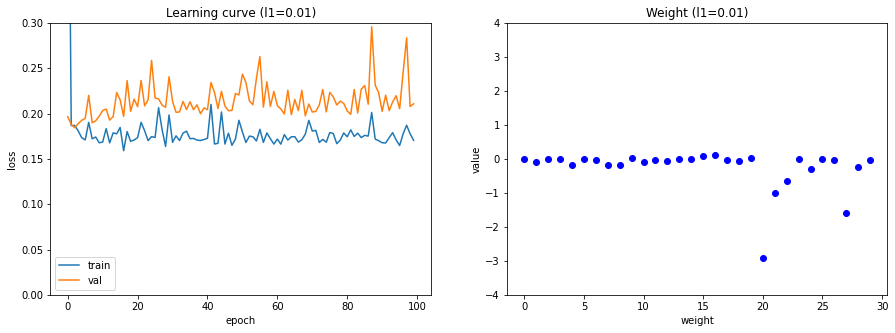

In [14]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, epochs=100, x_val=x_val_scaled, y_val=y_val)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title("Learning curve (l1={})".format(l1))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.ylim(0, 0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l1={})'.format(l1))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    
    plt.show()

In [22]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

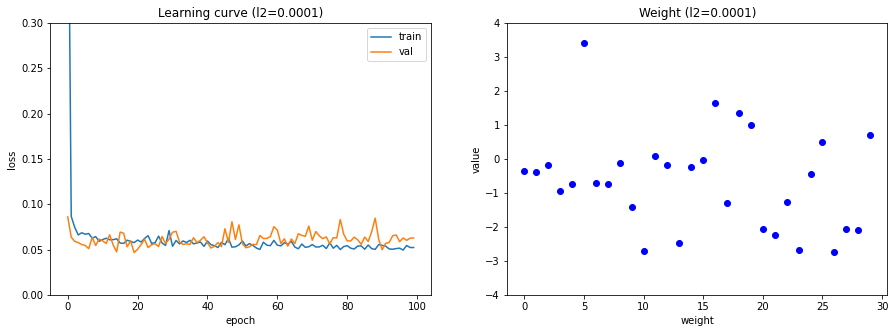

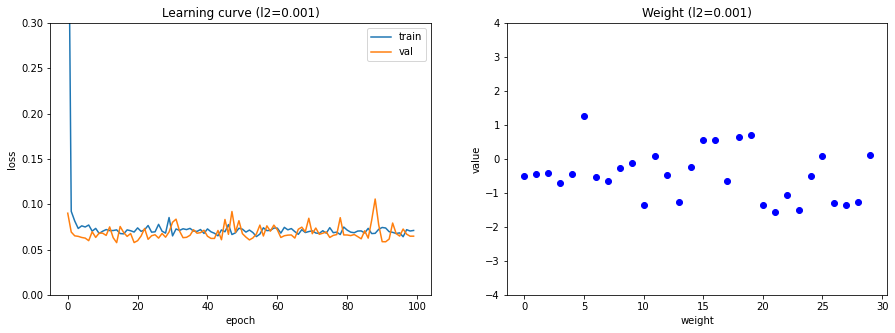

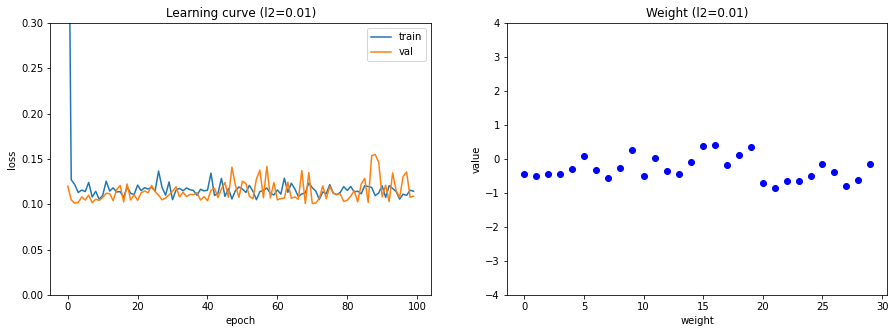

In [23]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, epochs=100, x_val=x_val_scaled, y_val=y_val)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title("Learning curve (l2={})".format(l2))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.ylim(0, 0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(lyr.w, 'bo')
    plt.title('Weight (l2={})'.format(l2))
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    
    plt.show()

In [25]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

In [28]:
np.sum(layer6.predict(x_val_scaled) == y_val)

89

In [29]:
from sklearn.linear_model import SGDClassifier

In [31]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

### 교차 검증

In [35]:
x.shape

(569, 30)

In [41]:
validation_scores = []
scaler = StandardScaler()

k = 10
bins = len(x) // k

for i in range(k):
    
    start = i * bins
    end = (i + 1) * bins
    
    train_index = list(range(start)) + list(range(end, len(x)))
    train_fold = x[train_index]
    train_target = y[train_index]
    
    val_fold = x[start:end]
    val_target = y[start:end]
    
    
    scaler.fit(train_fold)
    x_train_scaled = scaler.transform(train_fold)
    x_val_scaled = scaler.transform(val_fold)
    
    lyr = SingleLayer(l2=0.01)
    lyr.fit(x_train_scaled, train_target, epochs=50)
    score = lyr.score(x_val_scaled, val_target)
    validation_scores.append(score)
    
np.mean(validation_scores)

0.9803571428571427

In [49]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

In [50]:
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001, random_state=42)
pipe = make_pipeline(StandardScaler(), sgd)
score = cross_validate(pipe, x, y, cv=10, return_train_score=True)

In [52]:
np.mean(score['test_score']), np.mean(score['train_score'])

(0.9683897243107771, 0.9843780458089668)

In [20]:
class SingleLayer:
    
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(1 * err) / m
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + (self.l2 / 2) * np.sum(self.w**2)
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy())
        m = len(x)
        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop(x, err)
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(- (y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_losses(x_val, y_val)
            
    def update_val_losses(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(- (y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        m = len(x_val)
        self.val_losses.append((val_loss + self.reg_loss()) / m)
            
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [18]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [21]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, epochs=10000, x_val=x_val_scaled, y_val=y_val)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

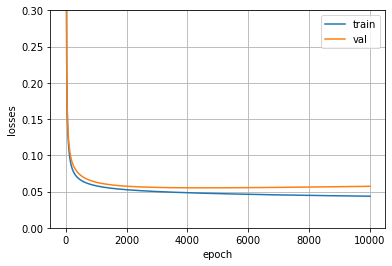

In [25]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.xlabel("epoch")
plt.ylabel("losses")
plt.legend(["train", "val"])
plt.grid()
plt.show()

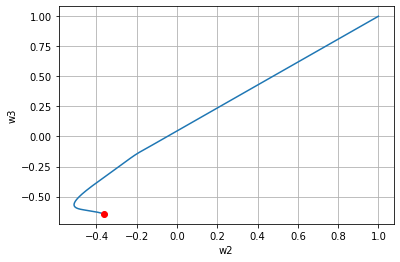

In [29]:
w2 = []
w3 = []

for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
    
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel("w2")
plt.ylabel("w3")
plt.grid()
plt.show()